In [1]:
import os
import re

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# This one is for files that originate from a google drive (scraped data)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We scraped tweets and stored them as text files in dataset. The cell below gets the tweets from the files and stores them in text_examples

In [3]:
folder_path = '/content/drive/My Drive/Colab Notebooks/dataset/'
def read_folder(folder):
    examples = []
    for subdir in os.listdir(folder):
        subdir_path = os.path.join(folder, subdir)
        if os.path.isdir(subdir_path):  # Check if it's a directory
            files_read = 0  # Counter for the number of files read from each folder
            for fname in os.listdir(subdir_path):
                file_path = os.path.join(subdir_path, fname)
                if os.path.isfile(file_path) and file_path.endswith('.txt'):  # Check if it's a file and ends with '.txt'
                    with open(file_path, encoding='utf8') as f:
                        examples.append(f.readline().strip())
    return examples
test_examples = read_folder(folder_path)
print('Number of examples: {}'.format(len(test_examples)))
print('Sample example: {}\n\n'.format(test_examples[0]))
print(test_examples[:10])

Number of examples: 7657
Sample example: Sheffield United manager Chris Wilder has confirmed that Jadon Bogle and Jack Robinson will miss their upcoming #PL match against Burnley due to their injuries.   #SUFC


['Sheffield United manager Chris Wilder has confirmed that Jadon Bogle and Jack Robinson will miss their upcoming #PL match against Burnley due to their injuries.   #SUFC', 'Whatever the outcome on Saturday, what a season it s been.  Let s go one final time on Saturday!   ️ #SUFC #RootsHall', "Aldershot and Gateshead tease each other over 'hoo-ha' for postponed fixture - https://t.co/8C9veElgPk  #afc #avfc #afcb #brentfordfc #bhafc #twitterclarets #cfc #cpfc #efc #ffc #lfc #coyh #ltfc #mancity #mufc #nufc #nffc #twitterblades #sufc #thfc #coys #whufc #coyi #wwfc", 'Prince Abdullah on Instagram. #twitterblades #sufc https://t.co/gkV3YwUrwL', 'Barnsley player gets hit in the head by Portsmouth fan during pitch invasion -  https://t.co/Wloq1qLlcZ  #afc #avfc #afcb #brentfordfc #bh

In [4]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


This is to get the sentiments of each tweet because they are unlabelled originally

In [5]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [6]:
soccer_df = pd.DataFrame({'text': test_examples})
print(soccer_df)

                                                   text
0     Sheffield United manager Chris Wilder has conf...
1     Whatever the outcome on Saturday, what a seaso...
2     Aldershot and Gateshead tease each other over ...
3     Prince Abdullah on Instagram. #twitterblades #...
4     Barnsley player gets hit in the head by Portsm...
...                                                 ...
7652  Although, Wilcox is appointed but Utd's curren...
7653  #mufc Revoke The United Stand's Press Credenti...
7654  Sancho s bonuses for getting into the champion...
7655  #Sirjim is doing a great work at Manchester Un...
7656  EXCLUSIVE: Manchester United have agreed compe...

[7657 rows x 1 columns]


In [7]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '#AFC')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '#name'
    text = re.sub(r'#\w+(\s|$)', ' ', text)


    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove links
    text = re.sub(r'https?://\S+', '', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

sia = SentimentIntensityAnalyzer()
def compute_sentiment(text):
    # Preprocess the text (if needed)
    preprocessed_text = text_preprocessing(text)

    # Compute sentiment score
    scores = sia.polarity_scores(preprocessed_text)

    return scores['compound']

soccer_df['sentiment_score'] = soccer_df['text'].apply(compute_sentiment)

def categorize_sentiment(score):
  if score >= 0:
    return 1
  else:
    return 0

soccer_df['sentiment'] = soccer_df['sentiment_score'].apply(categorize_sentiment)

In [8]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def text_preprocessing(s):
  '''
  - change all to lowercase
  - change "'t" to "not"
  - remove "@name"
  - remove punctuations except "?"
  - remove stop words except "not" and "can"
  - remove trailing whitespace
  '''
  # lower case
  s = s.lower()
  # change 't to not
  s = re.sub(r"\'t", " not", s)
  # remove @name
  s = re.sub(r'(@.*?)[\s]', ' ', s)
  # Isolate and remove punctuations except '?'
  s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r'  ', s)
  s = re.sub(r'[^\w\s\?]', ' ', s)
  # Remove some special characters
  s = re.sub(r'([\;\:\|•«\n])', ' ', s)
  # Remove stopwords except 'not' and 'can'
  s = " ".join([word for word in s.split()
                if word not in stopwords.words('english')
                or word in ['not', 'can']])
  # Remove trailing whitespace
  s = re.sub(r'\s+', ' ', s).strip()

  return s


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


We want training, validation, and testing data.

In [9]:
from sklearn.model_selection import train_test_split

X = soccer_df.text.values
y = soccer_df.sentiment.values
X_train, X_other, y_train, y_other = train_test_split(X, y, test_size = 0.3, random_state = 2020)
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size = 0.5, random_state = 2020)

In [10]:
print('X_train: ', X_train[:5])
print('X_val: ', X_val[:5])
print('y_train: ', y_train[:5])
print('y_val: ', y_val[:5])

X_train:  ['Enzo Fernandez, Axel Disasi and Raheem Sterling have been taken off Chelsea\'s injury list. And Nkunku is in "partial team training." #CFC #EmiratesFACup'
 "If there's one thing I can be proud of this season, it's that Carrington is still producing quality players        Kobbie   &amp; Alejandro  #MUFC"
 'Pochettino on Palmer:  But it s true we are a coaching staff that we always demand more.  Yes you score, but you need to work. Yes you score, but you need to run when we don t have the ball . But he s doing well.  [standard] #cfc'
 'Charlie Goode has returned to #BrentfordFC midway through his loan spell at Wigan due to  personal reasons  https://t.co/bg1vTvjH3i'
 'Glasner is the first person to arrive at the club s Copers Cope training ground and the last to leave.  Many at the club believe he is one to take them to the next level.   @iamrahmanosman #CPFC https://t.co/8MDUrGPYQc']
X_val:  ["9th tier club win 12-0 at league's worst side after needing 12 goal swing for play

In [11]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess X_train and X_val separately
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])
X_test_preprocessed = np.array([text_preprocessing(text) for text in X_test])

# Initialize TF-IDF vectorizer
tf_idf = TfidfVectorizer(ngram_range=(1, 3), binary=True, smooth_idf=False)

# Fit and transform TF-IDF vectorizer on X_train_preprocessed
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)

# Transform X_val_preprocessed and X_test_preprocessed using the fitted TF-IDF vectorizer
X_val_tfidf = tf_idf.transform(X_val_preprocessed)
X_test_tfidf = tf_idf.transform(X_test_preprocessed)

CPU times: user 25.5 s, sys: 3.54 s, total: 29 s
Wall time: 29.9 s


In [12]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from scipy.sparse import vstack

def get_auc_CV(model):
    '''
    Return the average AUC score from cross-validation
    '''
    # Set KFold to shuffle data pre-split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Concatenate training and validation features
    X_train_val = vstack((X_train_tfidf, X_val_tfidf))

    # Concatenate training and validation target labels
    y_train_val = np.concatenate((y_train, y_val))

    # Get AUC scores
    auc = cross_val_score(model, X_train_val, y_train_val, scoring="roc_auc", cv=kf)
    return auc.mean()

We want to optimize the hyperparameter of alpha

Best alpha:  0.14


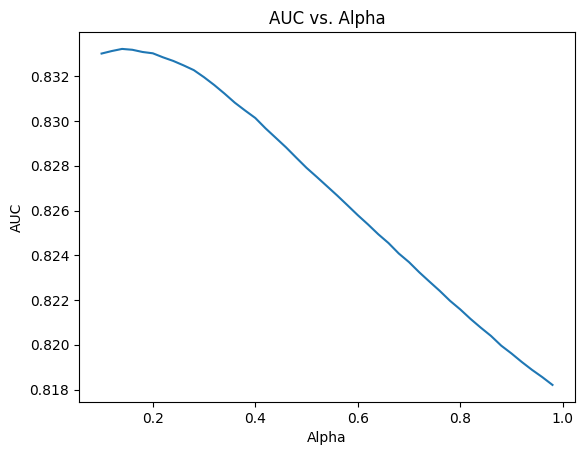

In [13]:
from sklearn.naive_bayes import MultinomialNB

res = pd.Series([get_auc_CV(MultinomialNB(alpha = i))
                 for i in np.arange(0.1, 1, 0.02)],
                index=np.arange(0.1, 1, 0.02))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

In [15]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
  '''
  - print auc and accuracy on validation set
  - plot roc
  @params   probs (np.array): array of predicted probabilities with shape (len(y_true), 2)
  @params   y_true (np.array): array of the true values with shape (len(y_true),)
  '''
  preds = probs[:, 1]
  fpr, tpr, threshold = roc_curve(y_true, preds)
  roc_auc = auc(fpr, tpr)
  print(f'AUC: {roc_auc:.4f}')
  # accuracy over test set
  y_pred = np.where(preds >= 0.5, 1, 0)
  accuracy = accuracy_score(y_true, y_pred)
  print(f'Accuracy: {accuracy*100:.2f}%')

  # plot ROC AUC
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()


AUC: 0.8858
Accuracy: 86.34%


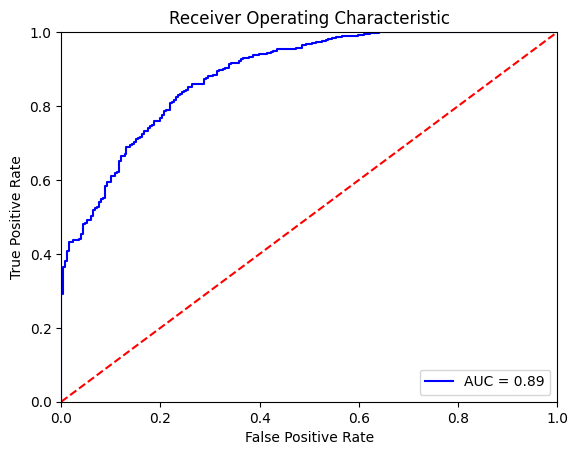

In [16]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=best_alpha)
nb_model.fit(vstack((X_train_tfidf, X_val_tfidf)), np.concatenate((y_train, y_val)))
probs = nb_model.predict_proba(X_test_tfidf)

# Evaluate the classifier
evaluate_roc(probs, y_test)

In [17]:
import numpy as np
from sklearn.metrics import f1_score

# Threshold the probabilities to get binary predictions
y_pred = np.where(probs[:, 1] >= 0.5, 1, 0)

# Compute the F1-score
f1 = f1_score(y_test, y_pred)

print("F1-score:", f1)


F1-score: 0.9191138588356517
